In [1]:
import tensorflow as tf
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pandas as pd
import autoencoder
import model
from datetime import datetime
from datetime import timedelta
sns.set()

## Deep Feed-forward Auto-Encoder Neural Network  to reduce dimension + Deep Recurrent Neural Network + ARIMA + Extreme Boosting Gradient Regressor

### Our target is Close market

In [2]:
google = pd.read_csv('../dataset/predict-set-20190527-0531.csv')
# 取500提高速度
#google = google.iloc[:500, :]

In [3]:
date_ori = pd.to_datetime(google.iloc[:, 0]).tolist()
google.head()


,Timestamp,High,Low,Open,Volume,Close
0,1558915200,8660.000000,8607.303062,8616.502752,20803.498272,8653.011422
1,1558915500,8729.091604,8653.815050,8653.815050,122780.290759,8689.545605
2,1558915800,8698.578593,8658.146320,8682.595359,48788.811247,8682.085232
3,1558916100,8733.177325,8700.000000,8700.000000,36294.412783,8733.177325
4,1558916400,8815.225937,8734.000000,8734.000000,164608.486049,8811.826574


In [4]:
minmax = MinMaxScaler().fit(google.iloc[:, 5].values.reshape((-1,1)))
df_log = MinMaxScaler().fit_transform(google.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4
0,0.561347,0.603841,0.526613,0.022655,0.573219
1,0.638965,0.654510,0.569281,0.133711,0.614819
2,0.604686,0.659228,0.602192,0.053132,0.606323
3,0.643555,0.704822,0.622094,0.039525,0.664501
4,0.735728,0.741861,0.660975,0.179262,0.754056


In [5]:
df_log.values[0, 4]
#google.iloc[:, 5]

0.5732186214446511

In [6]:
thought_vector = autoencoder.reducedimension(df_log.values, 4, 0.001, 128, 100)

Instructions for updating:
Colocations handled automatically by placer.
epoch: 10 loss: 0.17131525 time: 0.00234222412109375
epoch: 20 loss: 0.1712874 time: 0.00510716438293457
epoch: 30 loss: 0.17123967 time: 0.0027284622192382812
epoch: 40 loss: 0.17115726 time: 0.002460002899169922
epoch: 50 loss: 0.17101273 time: 0.002290487289428711
epoch: 60 loss: 0.17075324 time: 0.0024268627166748047
epoch: 70 loss: 0.17026797 time: 0.0026340484619140625
epoch: 80 loss: 0.16929778 time: 0.002160787582397461
epoch: 90 loss: 0.16716495 time: 0.004758358001708984
epoch: 100 loss: 0.16222677 time: 0.0032286643981933594


In [7]:
thought_vector.shape

(1294, 4)

In [8]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 250
dropout_rate = 0.1

In [9]:
tf.reset_default_graph()
modelnn = model.Model(0.01, num_layers, thought_vector.shape[1], size_layer, 1, dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, (thought_vector.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(thought_vector[k: k + timestamp, :], axis = 0)
        batch_y = df_log.values[k + 1: k + timestamp + 1, 4].reshape([-1, 1])
        last_state, _, loss = sess.run([modelnn.last_state, 
                                        modelnn.optimizer, 
                                        modelnn.cost], feed_dict={modelnn.X: batch_x, 
                                                                  modelnn.Y: batch_y, 
                                                                  modelnn.hidden_layer: init_value})
        init_value = last_state
        total_loss += loss
    total_loss /= (thought_vector.shape[0] // timestamp)
    if (i + 1) % 50 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 50 avg loss: 0.01881797732759399
epoch: 100 avg loss: 0.014364689741172654
epoch: 150 avg loss: 0.01179987650652066
epoch: 200 avg loss: 0.010799021637220614
epoch: 250 avg loss: 0.010172052172140324


In [10]:
output_predict = np.zeros(((thought_vector.shape[0] // timestamp) * timestamp, 1))
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (thought_vector.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(thought_vector[k: k + timestamp, :], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[k: k + timestamp, :] = out_logits

In [11]:
print('Mean Square Error:', np.mean(np.square(output_predict[:, 0] - df_log.iloc[1: (thought_vector.shape[0] // timestamp) * timestamp + 1, 0].values)))

Mean Square Error: 0.06840490496679512


In [12]:
print(output_predict)

[[0.31098893]
 [0.3671867 ]
 [0.34244552]
 ...
 [0.13508648]
 [0.12957773]
 [0.15161094]]


Import ARIMA model using stats model

In [13]:
import statsmodels.api as sm
from itertools import product
from scipy import stats
    
Qs = range(0, 1)
qs = range(0, 2)
Ps = range(0, 2)
ps = range(0, 2)
D=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
best_aic = float("inf")
for param in parameters_list:
    try:
        arima=sm.tsa.statespace.SARIMAX(df_log.iloc[:,4].values, order=(param[0], D, param[1]), seasonal_order=(param[2], D, param[3], 1)).fit(disp=-1)
    except:
        continue
    aic = arima.aic
    if aic < best_aic and aic:
        best_arima = arima
        best_aic = aic
        
best_aic

/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/s

-6237.931474951886

In [14]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

<IPython.core.display.Javascript object>


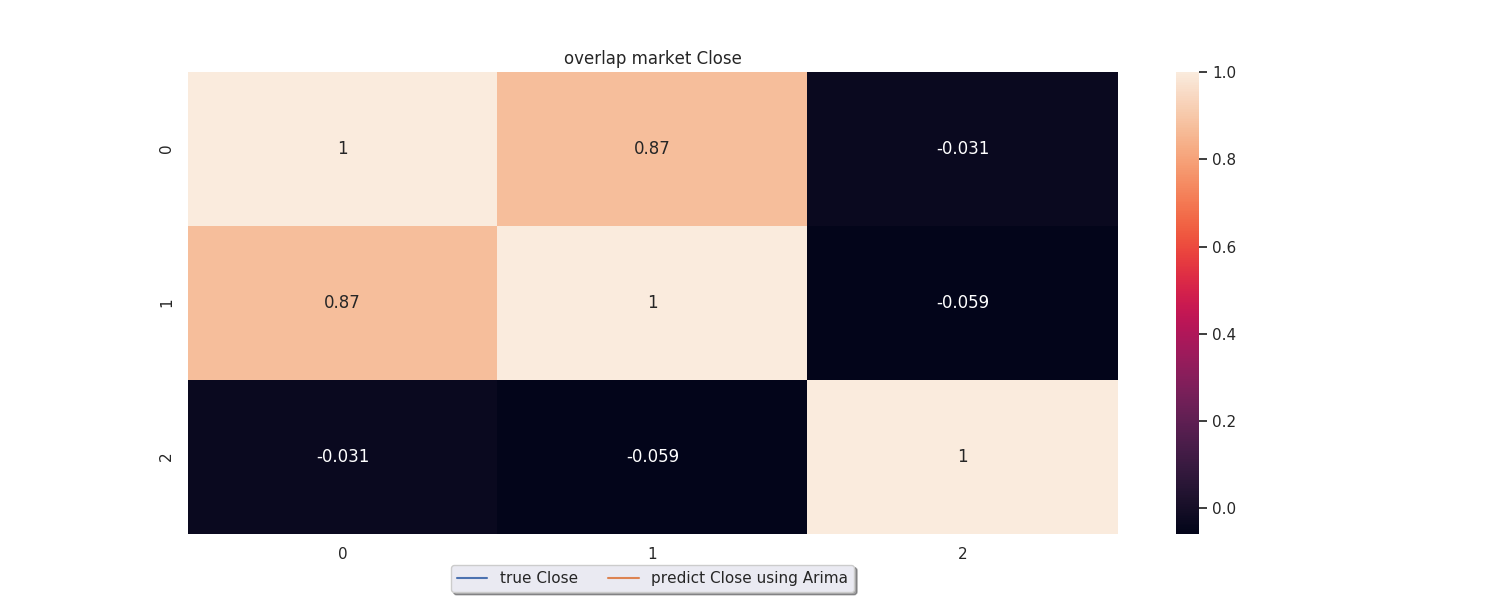

In [15]:
%matplotlib notebook

pred_arima = best_arima.predict()
x_range = np.arange(df_log.shape[0])
fig = plt.figure(figsize = (15,6))
ax = plt.subplot(111)
ax.plot(x_range, reverse_close(df_log.iloc[:,4].values), label = 'true Close')
ax.plot(x_range, reverse_close(pred_arima), label = 'predict Close using Arima')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.xticks(x_range[::5], date_ori[::5])
plt.title('overlap market Close')
plt.show()

In [16]:
boundary = (thought_vector.shape[0] // timestamp) * timestamp
stack_predict = np.vstack([pred_arima[:boundary], output_predict.reshape((-1))]).T

In [17]:
where_below_0 = np.where(stack_predict < 0)
where_higher_1 = np.where(stack_predict > 1)
stack_predict[where_below_0[0], where_below_0[1]] = 0
stack_predict[where_higher_1[0], where_higher_1[1]] = 1

In [18]:
corr_df = pd.DataFrame(np.hstack([stack_predict, df_log.values[:boundary, 3].reshape((-1,1))]))

In [19]:
sns.heatmap(corr_df.corr(), annot= True)
plt.show()

ARIMA able to predict data that correlate 0.61 originally from original Close

Deep Recurrent Neural Network able to predict data that correlate 0.48 originally from original Close

In [20]:
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = df_log.values[:boundary, 4]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict,train_Y, eval_set=[(stack_predict,train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [21]:
stacked = clf.predict(stack_predict)

<IPython.core.display.Javascript object>


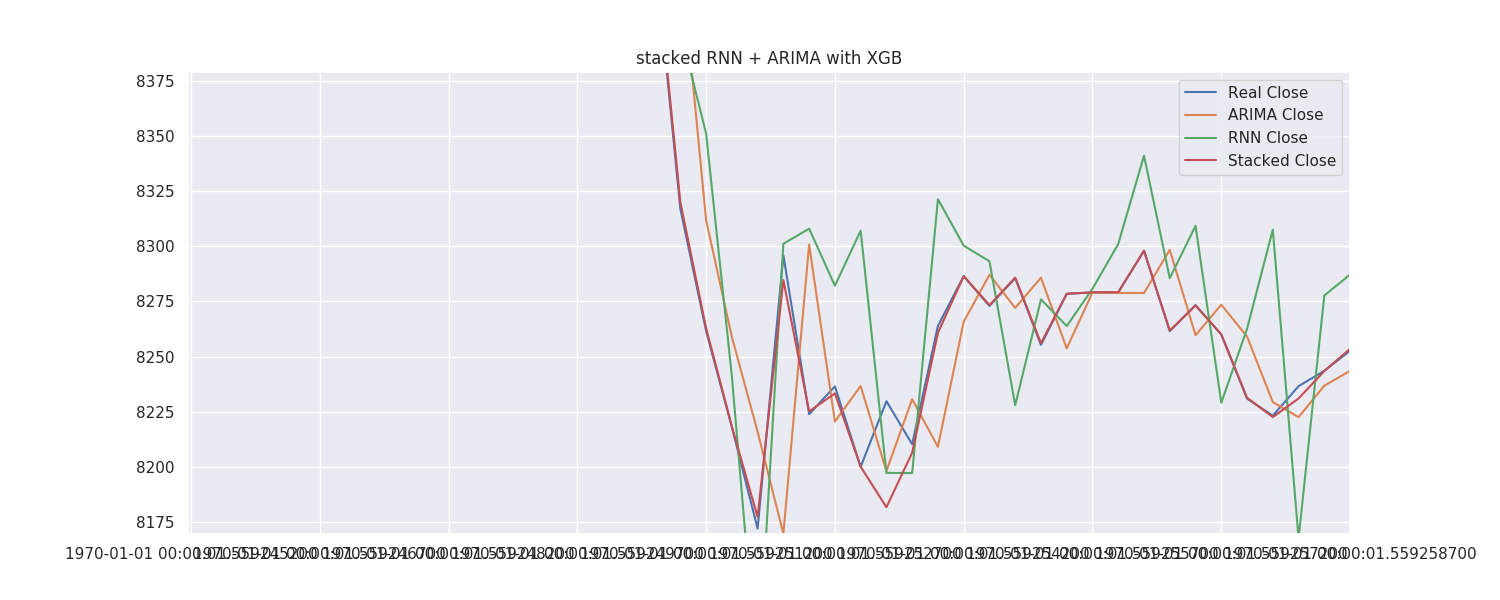

In [22]:
plt.figure(figsize = (15,6))
x_range = np.arange(boundary)
plt.plot(x_range, reverse_close(train_Y), label = 'Real Close')
plt.plot(x_range, reverse_close(pred_arima[:boundary]), label = 'ARIMA Close')
plt.plot(x_range, reverse_close(output_predict), label = 'RNN Close')
plt.plot(x_range, reverse_close(stacked), label = 'Stacked Close')
plt.legend()
plt.xticks(x_range[::5], date_ori[:boundary][::5])
plt.title('stacked RNN + ARIMA with XGB')
plt.show()

# Pretty insane i can say!

<IPython.core.display.Javascript object>


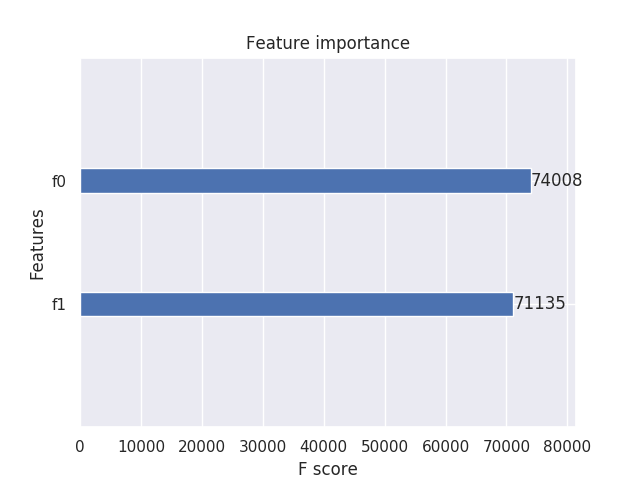

In [23]:
from xgboost import plot_importance
plot_importance(clf)
plt.show()

## Arima is more important than RNN